In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import balance

In [2]:
tables = balance.read_NIOT('NIOTS/RUS_NIOT_nov16.xlsx')
table = tables[14]
key = jax.random.PRNGKey(1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# __I\O - таблицы__

Пусть экономика состоит из $n$ промышленных отраслей, производящие __вторичные ресурсы__ и потребляющая $m$ видов __первичных ресурсов__, так же пусть имеется $l$ __конечных потребителей__, потребляющие вторичные ресурсы. Тогда можно ввести __I/O__-таблицу $\hat{Z}$ размера $(n+m)\times(n+l)$, в ячейках которой записаны потоки товаров из одной отрасли в другую.

Одним из примеров баз данных можно привести $NIOT$, разделяющую экономику на $n=56$ отраслей и $l = 6$ конечных потребителя. Так же в этих таблицах можно выделить $m=3$ первичных ресурса. Так как статистика потребления первичных ресурсов конечными потребителями в некотором смысле плохая, будем считать, что конечные потребители не потребляют первичные рессурсы.

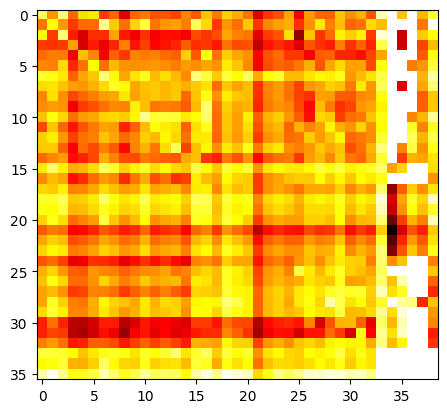

In [3]:
plt.imshow(jnp.log(table), cmap='hot', interpolation='nearest')
plt.show()

# __Производственные Функции__

Рассмотрим модель экономики, называемой __Межотраслевым Балансом__. Неформально ее можно описать как набор производственных функций и потребителей, которые закупаясь по некоторым рыночным ценам и максимизируя полезность\доход воспроизводят(приближенно) __I/O__-таблицы.   Допустимых функций бесконечно много - вопрос в том как такие найти. Хорошим классом является CES. Для любой корректной $\hat{Z}$ и люого $\rho\in\mathbb{R}^{n}_{++}$ существуют веса $W$, что в равновесных ценах пропорции воспроизведутся. Стартанем отсюда.

In [4]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
rho = jax.random.uniform(key, (n,), minval=1, maxval = 5)
W = balance.get_W(Z_hat, rho)

Имея на руках производственные функции можно найти равновесные цены, полагая $s$ зафиксированным(и единичным).

In [5]:
cost_f = jax.jit(lambda p: balance.CES(p, W, rho))
s = jnp.array(jnp.ones(m))
p = balance.get_prices(cost_f, n, s)

Имея равновесные цены $p$ можно рассчитать и пропорции потребления. Важно заметить, что это именно пропорции, а не точное воспроизведение.
В дальнейшем мы будем так же и масштабировать, чтоб получить функцию ошибки, и ее дифференциировать. Как видно они похожи, но не 1 в 1
(а разве не должны быть 1 в 1?)

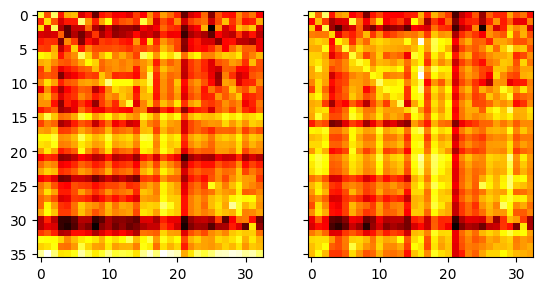

In [6]:
Z = balance.JCES(p, W, rho)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(Z), cmap='hot', interpolation='nearest')

Подгоним масштабирующие коэффициенты так, чтоб из пропорций потребления получились наиболее приближенными к данным. При этом очень важно учесть, что так же должен существовать и вектор конечного потребления, чтоб воспроизводилась корректная __I/O__-таблица. Поиск такий масштабирующих коэффициентов можно записать как задачу линейного программирования. 

In [7]:
J1, x, u = balance.primal_J(Z, Z_hat)
J1

3270418.221102603

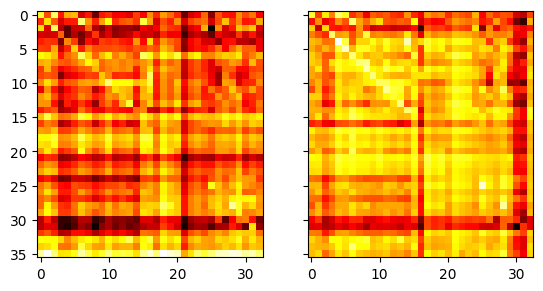

In [8]:
Z = balance.JCES(p, W, rho)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(x * Z), cmap='hot', interpolation='nearest')

In [9]:
jnp.sum(Z_hat - x * Z)/jnp.sum(Z_hat)

Array(0.9105051, dtype=float32)

Да чет ну совсем не похоже, оно объясняет только 10% от потребления.
Протестируем как вообще работает primal_J

Но по-хорошему оно должно в точности воспроизводить потребление $\hat{Z}$, а не приближенно. Более чем уверен, что ошибка в balance.get_W, но вроде все правильно. Поговорю на этот счет с научем. Во всем остальном уверен. Нужно посчитать $\nabla_{Z} J$ и попытаться _выучить_ пропорции $\hat{Z}$. Тогда можно будет раскручитвать подход дальше.

In [10]:
J2, nu, lam = balance.dual_J(Z, Z_hat)
J1, J2

(3270418.221102603, 3270418.2166799353)

In [11]:
(J1 - J2)/J1

1.3523247295297393e-09

In [12]:
balance.grad_J(Z, Z_hat)

Array([[ -7600.7544  ,  -3241.1526  ,  -1020.86694 , ...,   -524.97577 ,
          -129.8917  , -37358.875   ],
       [ -7420.1895  ,  -3165.942   ,   -989.0412  , ...,   -510.75406 ,
          -126.389595, -36805.703   ],
       [ -9409.574   ,  -3994.58    ,  -1339.6835  , ...,   -667.44226 ,
          -164.97412 , -42900.31    ],
       ...,
       [ -9409.574   ,  -3994.58    ,  -1339.6835  , ...,   -667.44226 ,
          -164.97412 , -42900.31    ],
       [ -9409.574   ,  -3994.58    ,  -1339.6835  , ...,   -667.44226 ,
          -164.97412 , -42900.31    ],
       [ -9409.574   ,  -3994.58    ,  -1339.6835  , ...,   -667.44226 ,
          -164.97412 , -42900.31    ]], dtype=float32)